# Classification task

* The goal is to train a neural network that maps an input image (from fashionMNIST) to one of ten classes (multi-class classification problem with mutually exclusive classes).
* Define a proper loss (e.g. [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss))
* Also here, consider to create a validation set from you training data, or use a k-fold cross-validation strategy.
* Pay attention to the shape, data type and output values range. If needed, modify them accordingly to your implementation (read carefully the documentation of the layers that you use, e.g. [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)).
* Explore different optimizers, acivation functions, network architectures. Analyze the effect of different regularization methods, such as dropout layers, random transformations (image rotation, scaling, add noise...) or L2 regularization (weight decay).

## Dataset

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
# test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)

Get an image and its corresponding label

SAMPLE AT INDEX 0
LABEL: 9


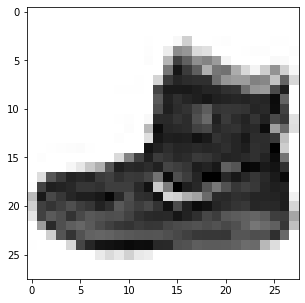

In [4]:
sample_index = 0
image = train_dataset[sample_index][0]
label = train_dataset[sample_index][1]

fig = plt.figure(figsize=(5,5))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

The output of the dataset is a PIL Image, a python object specifically developed to manage and process images. PyTorch supports this format, and there are useful transforms available natively in the framework: https://pytorch.org/docs/stable/torchvision/transforms.html


If you want, you can easily convert a PIL image to a numpy array and entirely ignore the PIL object:

In [6]:
image_numpy = np.array(image)

print(f'Numpy array shape: {image_numpy.shape}')
print(f'Numpy array type: {image_numpy.dtype}')

Numpy array shape: (28, 28)
Numpy array type: uint8


To transform a PIL Image directly to a PyTorch tensor, instead:

In [9]:
to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(image)

print(f'PyTorch tensor shape: {image_tensor.shape}')
print(f'PyTorch tensor type: {image_tensor.dtype}')

PyTorch tensor shape: torch.Size([1, 28, 28])
PyTorch tensor type: torch.float32


In [2]:
train_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) 

test_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) 

In [3]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True,transform=train_transform)

test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True,transform=test_transform)

In [4]:
#Define a validation dataset
train_percent = 0.8
n_train      = int(train_percent * len(train_dataset))
n_validation = len(train_dataset) - n_train
train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [n_train, n_validation])

print('# of training samples  :',len(train_dataset))
print('# of validation samples:',len(validation_dataset))
print('# of test samples      :',len(test_dataset))

# of training samples  : 48000
# of validation samples: 12000
# of test samples      : 10000


In [5]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


In [6]:
batch_size = 400
train_dataloader      = DataLoader(train_dataset,      batch_size=batch_size,              shuffle=True, num_workers=0)
validation_dataloader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=False, num_workers=0)
test_dataloader       = DataLoader(test_dataset,       batch_size=len(test_dataset),       shuffle=False, num_workers=0)

In [9]:
class ConvNet(nn.Module):
    def __init__(self,dropout_rate=0.5,dropout_rate2=0.1,linear_1=50,Nh1=16,Nh2=64):
        
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=Nh1, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=Nh1, out_channels=Nh2, kernel_size=5, stride=1, padding=2)
        
        self.drop1=nn.Dropout2d(p=dropout_rate)  
        #fully connected layer
        self.fc1 = nn.Linear(Nh2 * 7 * 7, linear_1)
        self.drop2=nn.Dropout2d(p=dropout_rate2)
        self.fc2 = nn.Linear(linear_1, 10)

    def forward(self, x):
        
        x = F.relu(F.max_pool2d(self.conv1(x),kernel_size = 2))
        x = F.relu(F.max_pool2d(self.conv2(x),kernel_size = 2))
        x = self.drop1(x)        
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        
        x = self.drop2(x)
        x = self.fc2(x)
        
        return x

In [10]:
# Initialize the network
torch.manual_seed(0)

net = ConvNet()
net.to(device)

ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (drop1): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=3136, out_features=50, bias=True)
  (drop2): Dropout2d(p=0.1, inplace=False)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [11]:
# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [12]:
### TRAINING LOOP
num_epochs = 10
train_loss_log = []
val_loss_log = []
for epoch_num in range(num_epochs):
    print('#################')
    print(f'# EPOCH {epoch_num}')
    print('#################')

    ### TRAIN
    train_loss= []
    net.train() # Training mode (e.g. enable dropout, batchnorm updates,...)
    for sample_batched in train_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        # Forward pass
        out = net(x_batch)

        # Compute loss
        loss = loss_fn(out, label_batch)

        # Backpropagation
        net.zero_grad()
        loss.backward()

        # Update the weights
        optimizer.step()

        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)

    # Save average train loss
    train_loss = np.mean(train_loss)
    print(f"AVERAGE TRAIN LOSS: {train_loss}")
    train_loss_log.append(train_loss)

    ### VALIDATION
    val_loss= []
    net.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
    with torch.no_grad(): # Disable gradient tracking
        for sample_batched in validation_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = net(x_batch)

            # Compute loss
            loss = loss_fn(out, label_batch)

            # Save val loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)

        # Save average validation loss
        val_loss = np.mean(val_loss)
        print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
        val_loss_log.append(val_loss)
    

#################
# EPOCH 0
#################


C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\torch\nn\functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


AVERAGE TRAIN LOSS: 0.934018075466156
AVERAGE VAL LOSS: 0.4853222668170929
#################
# EPOCH 1
#################
AVERAGE TRAIN LOSS: 0.6482259631156921
AVERAGE VAL LOSS: 0.41250255703926086
#################
# EPOCH 2
#################
AVERAGE TRAIN LOSS: 0.5885397791862488
AVERAGE VAL LOSS: 0.3752780854701996
#################
# EPOCH 3
#################
AVERAGE TRAIN LOSS: 0.5673002004623413
AVERAGE VAL LOSS: 0.35400861501693726
#################
# EPOCH 4
#################
AVERAGE TRAIN LOSS: 0.5442386865615845
AVERAGE VAL LOSS: 0.3376205265522003
#################
# EPOCH 5
#################
AVERAGE TRAIN LOSS: 0.5213916897773743
AVERAGE VAL LOSS: 0.3292308747768402
#################
# EPOCH 6
#################
AVERAGE TRAIN LOSS: 0.5101077556610107
AVERAGE VAL LOSS: 0.30865833163261414
#################
# EPOCH 7
#################
AVERAGE TRAIN LOSS: 0.49435654282569885
AVERAGE VAL LOSS: 0.29413294792175293
#################
# EPOCH 8
#################
AVERAGE TRAIN LOSS: 

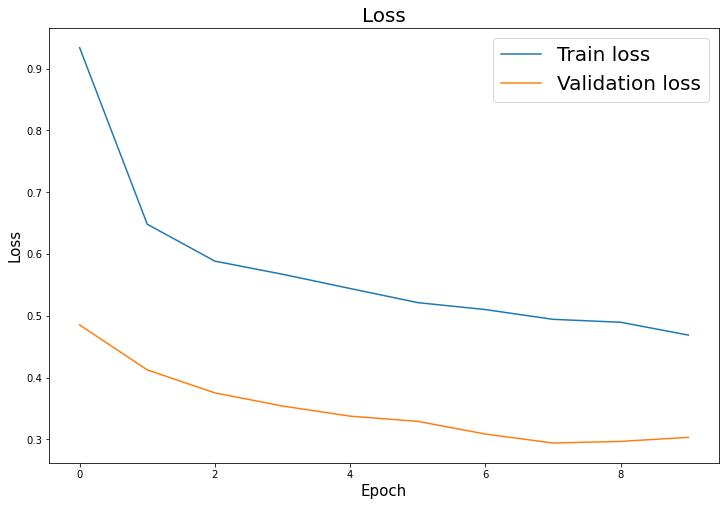

In [13]:
# Plot losses
plt.figure(figsize=(12,8))
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.title('Loss', fontsize = 20)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)

plt.legend(['Train loss', 'Validation loss'], loc='best', fontsize = 20)
plt.show()

In [16]:
all_inputs = []
all_outputs = []
all_labels = []
net.eval() # Evaluation mode (e.g. disable dropout)
with torch.no_grad(): # Disable gradient tracking
    for sample_batched in test_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)
        # Forward pass
        out = net(x_batch)
        # Save outputs and labels
        all_inputs.append(x_batch)
        all_outputs.append(out)
        all_labels.append(label_batch)
# Concatenate all the outputs and labels in a single tensor
all_inputs  = torch.cat(all_inputs)
all_outputs = torch.cat(all_outputs)
all_labels  = torch.cat(all_labels)

test_loss = loss_fn(all_outputs, all_labels)
print(f"AVERAGE TEST LOSS: {test_loss}")

AVERAGE TEST LOSS: 0.31034430861473083


In [29]:
y_pred = net.predict(test_dataloader,fit_dict.get('device'))
y_true = np.array([x[1] for x in test_dataset])

AttributeError: 'ConvNet' object has no attribute 'predict'

In [27]:
y_pred = model.predict(test_dataloader,fit_dict.get('device'))
y_true = np.array([x[1] for x in test_dataset])

unique, counts = np.unique(y_true, return_counts=True)
matrix = confusion_matrix( y_pred, y_true)


print("\n Confusion matrix (normalized)")
plt.figure(figsize = (9,6))
sns.heatmap(matrix/counts[:,None], annot=True, fmt =  "1.2f" , cmap="Reds" )
plt.show()

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets